In [1]:
import os
import re
import ast

import spacy

import pandas as pd
import numpy as np
import seaborn as sns

from datetime import date, datetime


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


pd.options.display.max_colwidth = 280

In [2]:
df = pd.read_csv("resources/table_clean_topjuly16.csv", index_col = 0)

df.head()

,tweet_id,date,full_text,user,entities,short_url,number_urls,hashtags,user_mentions,media_url,full_text_processed
0,1283356992803868672,2020-07-15 11:05:25,le patron du pétrole de schiste dit que les etats unis ont passé leur pic traduction ici,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/w5MuRmDNnN', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10159506535177281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [92, 115]}, {'url': 'https://t.co/...","['https://t.co/w5MuRmDNnN', 'https://t.co/kx6WIwPNSs']",2,[],[],no_media,patron pétrole schiste etats unis pic traduction ici
1,1282394849870852098,2020-07-12 19:22:12,six mois sur une planète en crise carnet de voyage de greta thunberg des états unis à davos,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/DEskLJXWqU', 'expanded_url': 'https://medium.com/@jmj.fanpage/six-mois-sur-une-plan%C3%A8te-en-crise-carnet-de-voyage-de-greta-thunberg-des-%C3%A9tats-unis-%C3%A0-davos-629d92cef9cd', 'display...",['https://t.co/DEskLJXWqU'],1,[],[],no_media,mois planète crise carnet voyage greta thunberg états unis davos
2,1280935871471144962,2020-07-08 18:44:45,matthieu auzanneau de the shift project à propos du pic pétrolier en europe d ici 2030 si on sort du pétrole pour le climat nous sommes sauvés de mad max,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/lAC3hwH4o2', 'expanded_url': 'https://www.goodplanet.info/2020/07/08/matthieu-auzanneau-de-the-shift-project-a-propos-du-pic-petrolier-en-europe-dici-2030-si-on-sort-du-petrole-pour-le-climat-...",['https://t.co/lAC3hwH4o2'],1,[],[],no_media,matthieu auzanneau the shift project propos pic pétrolier europe d ici 2030 sort pétrole climat sommes sauvés mad max
3,1280850548518981633,2020-07-08 13:05:42,interview 3 50 jean marc jancovici revient sur la question climatique et de la croissance pour lui nous ne nous occupons pas du problème climatique alors qu il menace des milliards de personnes et l économie mondiale,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/YBmq94THuR', 'expanded_url': 'https://www.youtube.com/watch?v=ZsMSF0l9kyM', 'display_url': 'youtube.com/watch?v=ZsMSF0…', 'indices': [224, 247]}]}",['https://t.co/YBmq94THuR'],1,[],[],no_media,interview 3 50 jean marc jancovici revient question climatique croissance occupons problème climatique qu menace milliards personnes l économie mondiale
4,1280180257669238795,2020-07-06 16:42:12,vers un plan de transformation de l économie en faveur du climat et de la résilience the shift project vidéo 5 50,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/TWYTNdhx7t', 'expanded_url': 'https://www.youtube.com/watch?v=3sePULu7YIs&feature=youtu.be', 'display_url': 'youtube.com/watch?v=3sePUL…', 'indices': [118, 141]}]}",['https://t.co/TWYTNdhx7t'],1,[],[],no_media,plan transformation l économie faveur climat résilience the shift project vidéo 5 50


In [4]:
df["short_url"].value_counts()

[]                             4188
['https://t.co/MPR4EvNgkr']      12
['https://t.co/Wv114ORtx6']      12
['https://t.co/EpUae2eJ56']      10
['https://t.co/II3T80W6yg']      10
                               ... 
['https://t.co/RN3o4NECuJ']       1
['https://t.co/eVlMXGa77f']       1
['https://t.co/MQq3uo2At7']       1
['https://t.co/oarzisWgJL']       1
['https://t.co/sP8LWh9fuj']       1
Name: short_url, Length: 4369, dtype: int64

In [3]:
brut = pd.read_csv("resources/extract/table_max_july15.csv")

brut.head()        

,Unnamed: 0,tweet_id,date,full_text,user,entities
0,0,1283356992803868672,2020-07-15 11:05:25,Le patron du pétrole de schiste dit que les Etats-Unis ont passé leur pic.\nTraduction ici : https://t.co/w5MuRmDNnN\n\nhttps://t.co/kx6WIwPNSs,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/w5MuRmDNnN', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10159506535177281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [92, 115]}, {'url': 'https://t.co/..."
1,1,1282394849870852098,2020-07-12 19:22:12,Six mois sur une planète en crise: Carnet de voyage de Greta Thunberg des États-Unis à Davos \nhttps://t.co/DEskLJXWqU,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/DEskLJXWqU', 'expanded_url': 'https://medium.com/@jmj.fanpage/six-mois-sur-une-plan%C3%A8te-en-crise-carnet-de-voyage-de-greta-thunberg-des-%C3%A9tats-unis-%C3%A0-davos-629d92cef9cd', 'display..."
2,2,1280935871471144962,2020-07-08 18:44:45,"Matthieu Auzanneau de The Shift Project à propos du pic pétrolier en Europe d’ici 2030 : « si on sort du pétrole pour le climat, nous sommes sauvés de Mad Max »\nhttps://t.co/lAC3hwH4o2",JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/lAC3hwH4o2', 'expanded_url': 'https://www.goodplanet.info/2020/07/08/matthieu-auzanneau-de-the-shift-project-a-propos-du-pic-petrolier-en-europe-dici-2030-si-on-sort-du-petrole-pour-le-climat-..."
3,3,1280850548518981633,2020-07-08 13:05:42,"Interview (3'50) : Jean-Marc Jancovici revient sur la question climatique et de la croissance. Pour lui, nous ne nous occupons pas du problème climatique alors qu’il menace des milliards de personnes et l’économie mondiale.\nhttps://t.co/YBmq94THuR",JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/YBmq94THuR', 'expanded_url': 'https://www.youtube.com/watch?v=ZsMSF0l9kyM', 'display_url': 'youtube.com/watch?v=ZsMSF0…', 'indices': [224, 247]}]}"
4,4,1280180257669238795,2020-07-06 16:42:12,Vers un Plan de transformation de l'économie en faveur du climat et de la résilience - The Shift Project (vidéo 5'50)\nhttps://t.co/TWYTNdhx7t,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/TWYTNdhx7t', 'expanded_url': 'https://www.youtube.com/watch?v=3sePULu7YIs&feature=youtu.be', 'display_url': 'youtube.com/watch?v=3sePUL…', 'indices': [118, 141]}]}"


### Des textes vides

In [24]:
df[df["full_text"].isna()]

,tweet_id,date,full_text,user,entities,short_url,number_urls,hashtags,user_mentions,media_url,full_text_processed
159,1226489238042091521,2020-02-09 12:53:16,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/Af6wgi4YAG', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_eni-est-ce-que-lon-appelle-un-p%C3%A9trolier-activity-6632216920605237248-3gyD', 'display_url': 'linkedin.com/p...",['https://t.co/Af6wgi4YAG'],1,[],[],no_media,NaN
169,1226240910532521984,2020-02-08 20:26:30,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/28vS5oMNA9', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_le-directeur-de-centrale-nantes-doit-%C3%AAtre-activity-6631440454661615616-Gkq1', 'display_url': 'linkedin.com...",['https://t.co/28vS5oMNA9'],1,[],[],no_media,NaN
197,1215071608840298498,2020-01-09 00:43:41,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/87aUdyrPMS', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10158888602852281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/87aUdyrPMS'],1,[],[],no_media,NaN
66,1199280950108205057,2019-11-26 10:57:14,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/en6gbWF867', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_5g-larcep-donne-le-coup-denvoi-aux-exp%C3%A9rimentations-activity-6605029251643248641-23Aw', 'display_url': 'li...",['https://t.co/en6gbWF867'],1,[],[],no_media,NaN
78,1198610352612794369,2019-11-24 14:32:31,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/IdOF0YInsh', 'expanded_url': 'https://www.linkedin.com/posts/jean-marc-jancovici_chinese-credit-collapse-is-imminent-activity-6603964102232682496-T3Ol', 'display_url': 'linkedin.com/posts/jean...",['https://t.co/IdOF0YInsh'],1,[],[],no_media,NaN
119,1066950650867650560,2018-11-26 07:03:52,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/mNX4rqx06D', 'expanded_url': 'https://www.facebook.com/54658232280/posts/10157840565017281/', 'display_url': 'facebook.com/54658232280/po…', 'indices': [0, 23]}]}",['https://t.co/mNX4rqx06D'],1,[],[],no_media,NaN
42,1055033296034451456,2018-10-24 09:48:34,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/b4jg4RPaNz', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157763499342281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/b4jg4RPaNz'],1,[],[],no_media,NaN
25,1014508307833384960,2018-07-04 13:56:43,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/W8OAPxcGXv', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157497343467281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/W8OAPxcGXv'],1,[],[],no_media,NaN
47,1012056866912985089,2018-06-27 19:35:34,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/hp2Lj65dxa', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157479600412281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/hp2Lj65dxa'],1,[],[],no_media,NaN
180,998975355066167297,2018-05-22 17:14:19,NaN,JMJancovici,"{'hashtags': [], 'symbols': [], 'user_mentions': [], 'urls': [{'url': 'https://t.co/ETeNue3DLK', 'expanded_url': 'https://www.facebook.com/jeanmarc.jancovici/posts/10157389523532281', 'display_url': 'facebook.com/jeanmarc.janco…', 'indices': [0, 23]}]}",['https://t.co/ETeNue3DLK'],1,[],[],no_media,NaN


In [7]:
# il y en avait 32

In [25]:
df["full_text"].isna().value_counts()

False    8844
True       29
Name: full_text, dtype: int64

In [8]:
df["full_text"].isna().value_counts()

False    8831
True       32
Name: full_text, dtype: int64

In [27]:
# why non utf-8 strings?

In [4]:
df["full_text_processed"] = df["full_text_processed"].values.astype("U")

In [8]:
df.shape

(8873, 11)

In [4]:
df.shape

(8482, 12)

In [14]:
brut.iloc[7549]

Unnamed: 0                                                                                                                                                                                                                                                                                        135
tweet_id                                                                                                                                                                                                                                                                          1219271834090250244
date                                                                                                                                                                                                                                                                              2020-01-20 14:53:52
full_text                                                                                                             

In [16]:
brut.iloc[7549]["entities"]

"{'hashtags': [], 'symbols': [], 'user_mentions': [{'screen_name': 'Jardin_Acide', 'name': 'Nabil Laroussi', 'id': 862427256509128704, 'id_str': '862427256509128704', 'indices': [0, 13]}], 'urls': [], 'media': [{'id': 1219271829304545281, 'id_str': '1219271829304545281', 'indices': [37, 60], 'media_url': 'http://pbs.twimg.com/media/EOu5RM5WkAE-c7t.jpg', 'media_url_https': 'https://pbs.twimg.com/media/EOu5RM5WkAE-c7t.jpg', 'url': 'https://t.co/6ZSTLviAut', 'display_url': 'pic.twitter.com/6ZSTLviAut', 'expanded_url': 'https://twitter.com/maxcordiez/status/1219271834090250244/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 701, 'resize': 'fit'}, 'small': {'w': 680, 'h': 398, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1348, 'h': 788, 'resize': 'fit'}}}]}"

In [11]:
df.iloc[7549]

tweet_id                                                                                                                                                                                                                                                                                   1219271834090250244
date                                                                                                                                                                                                                                                                                       2020-01-20 14:53:52
full_text                                                                                                                                                                                                                                               jardin_acide ou de l algérie 6 x https t co 6zstlviaut
user                                                                                       

In [9]:
df["media_url"].value_counts()

no_media                       8175
['https://t.co/z0ugMNPHWH']       2
['https://t.co/lqaWqRFesZ']       2
['https://t.co/WboetMftjB']       2
['https://t.co/M7I4fotF4g']       2
                               ... 
['https://t.co/EYUSW1JLxc']       1
['https://t.co/81vrNHQjYU']       1
['https://t.co/BpTsrooZTc']       1
['https://t.co/tZwe7cNq7p']       1
['https://t.co/WtVDlPkE3w']       1
Name: media_url, Length: 694, dtype: int64

In [24]:
df.iloc[7542]["media_url"]

'no_media'

In [23]:
len(df.iloc[7542]["media_url"])

8

In [10]:
df["user_mentions"].value_counts()

[]                                                                                                  4284
['theShiftPR0JECT']                                                                                  209
['Carbone4']                                                                                         132
['maxcordiez']                                                                                        55
['bensabaugcap']                                                                                      43
                                                                                                    ... 
['boris_lengoc', 'sdnfr', 'TristanKamin', 'Kako_line', 'AStrochnis', 'BenjiLAREDO', 'MacLesggy']       1
['nntaleb']                                                                                            1
['laydgeur', 'LoveIslandFR', 'Nabilla']                                                                1
['bensabaugcap', 'XavierGorce']                        

In [5]:
brut.iloc[7549]["full_text"]

'« Nous estimons que près d’un cinquième de la ↗️ mondiale de la consommation d’#énergie en 2018 est imputable à des étés plus chauds, poussant à la hausse la demande de refroidissement, et aux vagues de froid, entraînant une augmentation des besoins en chauffage. » @IEA, WEO2019 https://t.co/u4ln0a7m5R'

In [4]:
brut.iloc[7549].entities

"{'hashtags': [{'text': 'énergie', 'indices': [79, 87]}], 'symbols': [], 'user_mentions': [{'screen_name': 'IEA', 'name': 'IEA', 'id': 84679163, 'id_str': '84679163', 'indices': [266, 270]}], 'urls': [], 'media': [{'id': 1194993950194573312, 'id_str': '1194993950194573312', 'indices': [280, 303], 'media_url': 'http://pbs.twimg.com/media/EJV4qpYWoAASbdK.png', 'media_url_https': 'https://pbs.twimg.com/media/EJV4qpYWoAASbdK.png', 'url': 'https://t.co/u4ln0a7m5R', 'display_url': 'pic.twitter.com/u4ln0a7m5R', 'expanded_url': 'https://twitter.com/maxcordiez/status/1194993954330173446/photo/1', 'type': 'photo', 'sizes': {'medium': {'w': 1200, 'h': 529, 'resize': 'fit'}, 'small': {'w': 680, 'h': 300, 'resize': 'fit'}, 'thumb': {'w': 150, 'h': 150, 'resize': 'crop'}, 'large': {'w': 1335, 'h': 589, 'resize': 'fit'}}}]}"

In [20]:
brut.iloc[6274]["full_text"] 

"Les fournisseurs d'électricité alternatifs (à EDF) sont contents de pouvoir acheter de l'électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif #ARENH quand elle coûte cher.\n\n[1/X]\n\nhttps://t.co/a2OwJa9vMW"

In [27]:
df.iloc[6274]["full_text"] 

'les fournisseurs d électricité alternatifs à edf sont contents de pouvoir acheter de l électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif arenh quand elle coûte cher 1 x '

In [21]:
df.iloc[6274]

tweet_id                                                                                                                                                                                                                                                                                   1247549090289856512
date                                                                                                                                                                                                                                                                                       2020-04-07 15:37:36
full_text                                                                les fournisseurs d électricité alternatifs à edf sont contents de pouvoir acheter de l électricité nucléaire à bas prix pour la revendre en faisant une marge via le dispositif arenh quand elle coûte cher 1 x https t co a2owja9vmw
user                                                                                       

In [28]:
# tokens uniques
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["full_text_processed"])
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0_c59e2fd7a9', '0vinz', '0xilight', '10', '100', '1000', '10000', '100000', '1000ppm', '100k', '103', '105', '10500', '1055', '107', '10bn', '10e', '10gco2', '10h', '10h20', '10mds', '10mrd', '10àlasuite', '10ème', '11', '110', '1100', '11000', '111', '112', '113', '114', '115013739', '117', '1170', '119', '11h', '11ème', '12', '120', '1200', '121', '122', '123', '1240', '125', '1250', '1258', '12gco2', '12h', '12h00', '12h08', '12h14h', '12h30', '12h40', '12k', '13', '130', '1300', '131', '133', '1332', '1335', '1346', '135', '1350', '137', '13h', '13h15', '13h30', '14', '140', '141', '144', '145', '1458', '147', '1479', '14h', '14h00', '14h15', '14h30', '15', '150', '1500', '15000', '150k', '151', '157', '159', '15h', '15h00', '15marches', '16', '160', '164', '16h', '16h30', '16th', '17', '170', '172', '173', '175', '176', '1782', '17h', '17h30', '17h40', '17h45', '17th', '18', '180', '1800', '180degresvp', '1817', 

In [29]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df["full_text_processed"])
print(vectorizer.get_feature_names())

['00', '000', '01', '02', '03', '04', '05', '06', '07', '08', '09', '0_c59e2fd7a9', '0vinz', '0xilight', '10', '100', '1000', '10000', '100000', '1000ppm', '100k', '103', '105', '10500', '1055', '107', '10bn', '10e', '10gco2', '10h', '10h20', '10mds', '10mrd', '10àlasuite', '10ème', '11', '110', '1100', '11000', '111', '112', '113', '114', '115013739', '117', '1170', '119', '11h', '11ème', '12', '120', '1200', '121', '122', '123', '1240', '125', '1250', '1258', '12gco2', '12h', '12h00', '12h08', '12h14h', '12h30', '12h40', '12k', '13', '130', '1300', '131', '133', '1332', '1335', '1346', '135', '1350', '137', '13h', '13h15', '13h30', '14', '140', '141', '144', '145', '1458', '147', '1479', '14h', '14h00', '14h15', '14h30', '15', '150', '1500', '15000', '150k', '151', '157', '159', '15h', '15h00', '15marches', '16', '160', '164', '16h', '16h30', '16th', '17', '170', '172', '173', '175', '176', '1782', '17h', '17h30', '17h40', '17h45', '17th', '18', '180', '1800', '180degresvp', '1817', 

In [8]:
X

<8482x19319 sparse matrix of type '<class 'numpy.float64'>'
	with 101352 stored elements in Compressed Sparse Row format>

In [30]:
vectorizer = TfidfVectorizer()
vectors = vectorizer.fit_transform(df["full_text_processed"])
feature_names = vectorizer.get_feature_names()
dense = vectors.todense()
denselist = dense.tolist()
df_tfidf = pd.DataFrame(denselist, columns=feature_names)
df_tfidf

,00,000,01,02,03,04,05,06,07,08,...,опек,перед,путина,разговора,разрывом,сделки,содержание,узнал,шax,چادری
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8868,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8869,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8870,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8871,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["full_text_processed"])

In [33]:
df.columns

Index(['00', '000', '01', '02', '03', '04', '05', '06', '07', '08',
       ...
       'опек', 'перед', 'путина', 'разговора', 'разрывом', 'сделки',
       'содержание', 'узнал', 'шax', 'چادری'],
      dtype='object', length=20153)

In [ ]:
#tokenization
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) # deacc=True removes punctuations
data_words = list(sent_to_words(data))

# création de bigram et trigram pour analyse ultérieures
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# Définir les fonctions pour les stopwords, bigrams et lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation (https://spacy.io/api/annotation)"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

# Retirer les Stopwords
data_words_nostops = remove_stopwords(data_words)

# Créer les bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# S'assurer que spacy utilise la langue approprié pour le corpus (dans ce cas-ci l'anglais)
# Télécharger la langue au besoin avec cette commande dans un terminal
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Lemmatization (permet de ne conserver que les noms, adj, verbes et adverbes)
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [ ]:
#SUR LES LEMS
#Ici le calcul des descripteurs est uniquement exploratoire, il s'agit de faire ressortir les associations de mots fréquentes afin de fusionner celles qui forment une expression sensée

#Matrice des bigrams (association de deux mots)
vect_count_bigrams = CountVectorizer(min_df=5, ngram_range=(2,2)).fit(dff['lemmas'])
lem_gram_vect = vect_count_bigrams.transform(dff['lemmas'])
lem_gram = pd.DataFrame(lem_gram_vect.todense()).rename(columns=renomecol(vect_count_bigrams))

#Matrice des trigrams (association de trois mots)
vect_count_trigrams = CountVectorizer(min_df=1, ngram_range=(3,3)).fit(dff['lemmas'])
lem_trigram_vect = vect_count_trigrams.transform(dff['lemmas'])
lem_trigram = pd.DataFrame(lem_trigram_vect.todense()).rename(columns=renomecol(vect_count_trigrams))

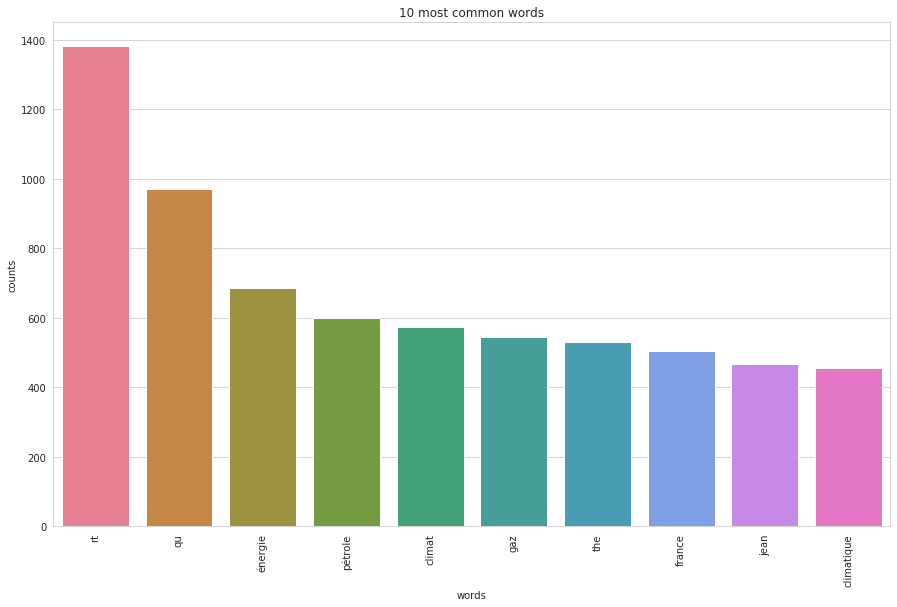

In [5]:
def plot_10_most_common_words(count_data, count_vectorizer):
    import matplotlib.pyplot as plt
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts+=t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)[0:10]
    words = [w[0] for w in count_dict]
    counts = [w[1] for w in count_dict]
    x_pos = np.arange(len(words)) 
    
    plt.figure(2, figsize=(15, 15/1.6180))
    plt.subplot(title='10 most common words')
    sns.set_context("notebook", font_scale=1.25, rc={"lines.linewidth": 2.5})
    sns.barplot(x_pos, counts, palette='husl')
    plt.xticks(x_pos, words, rotation=90) 
    plt.xlabel('words')
    plt.ylabel('counts')
    plt.show()
count_vectorizer = CountVectorizer(ngram_range=(1, 2))# Fit and transform the processed titles
count_data = count_vectorizer.fit_transform(df["full_text_processed"])# Visualise the 10 most common words
plot_10_most_common_words(count_data, count_vectorizer)

In [6]:
import warnings
warnings.simplefilter("ignore", DeprecationWarning)# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
 
# Helper function
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        
# Tweak the two parameters below
number_topics = 15
number_words = 200# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(count_data)# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, count_vectorizer, number_words)

Topics found via LDA:

Topic #0:
jean jancovici marc jean marc marc jancovici qu énergie article rt article jean climat france commentaire interview 2018 conférence conférence jean ans commentaire jean nucléaire économie publié pétrole voir vidéo interview jean pic électricité ici 2019 cas europe source greenpeacefr climatique 2017 fois faire déjà monde temps crise pierre 2020 thème carbone croissance revoir électrique dieterlen pierre dieterlen lire économique publié pierre compte mai table voir revoir avril theshiftpr0ject énergétique voiture rapport chiffres 10 thinkerview 100 problème baril faut jour risque ronde table ronde changement the 30 part vie demain livre moment planète question echos partie mois unis mal débat devrait joëlle publié joëlle cycle production niveau mieux électriques voitures 15 cours explique 11 13 pétrolier source énergie transition etats to mondiale oui 12 lundi émissions live paris graphique centrale fin pluriannuelle pluriannuelle énergie pays of écologi

In [7]:
%%time

from pyLDAvis import sklearn as sklearn_lda

import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()



LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)
        


LDAvis_prepared

CPU times: user 54.1 s, sys: 251 ms, total: 54.3 s
Wall time: 59.2 s


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
10    -0.079708  0.127629       1        1  8.834731
4      0.005173 -0.018503       2        1  7.991404
0      0.170839  0.076259       3        1  7.490638
8     -0.043630  0.014177       4        1  7.441456
14    -0.010294  0.074287       5        1  7.291981
6     -0.040833 -0.003241       6        1  7.158231
9     -0.017691 -0.090711       7        1  6.452290
3      0.063939 -0.046052       8        1  6.416106
7     -0.009856 -0.004114       9        1  6.264880
13    -0.000355 -0.009291      10        1  6.244046
5     -0.037797 -0.005124      11        1  6.243517
1     -0.009587 -0.029303      12        1  6.234401
12    -0.027031 -0.011093      13        1  5.716779
11     0.048062 -0.030836      14        1  5.437589
2     -0.011232 -0.044084      15        1  4.781952, topic_info=                 Term        Freq       Total Category  logprob  loglift
56709            marc  284.000000  284.000000  Default  30.0000  30.0000
51536            jean  332.000000  332.000000  Default  29.0000  29.0000
51556       jean marc  281.000000  281.000000  Default  28.0000  28.0000
56715  marc jancovici  276.000000  276.000000  Default  27.0000  27.0000
51113       jancovici  305.000000  305.000000  Default  26.0000  26.0000
...               ...         ...         ...      ...      ...      ...
59776           monde    8.719203  234.482644  Topic15  -7.1288  -0.2515
50554              is    7.539178  113.373776  Topic15  -7.2743   0.3297
36972           faire    8.478486  254.148738  Topic15  -7.1568  -0.3601
42197             gaz    8.916696  387.038639  Topic15  -7.1064  -0.7303
15468         carbone    7.767721  280.121475  Topic15  -7.2444  -0.5449

[1197 rows x 6 columns], token_table=        Topic      Freq                   Term
term                                          
124         1  0.156684                     10
124         2  0.068549                     10
124         3  0.097927                     10
124         4  0.029378                     10
124         5  0.068549                     10
...       ...       ...                    ...
102913      8  0.257463                étendue
102913     12  0.257463                étendue
102913     15  0.514925                étendue
103153      4  0.712074  évaluation climatique
103295      1  0.820594        éviter émission

[3711 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 1, 9, 15, 7, 10, 4, 8, 14, 6, 2, 13, 12, 3])

In [38]:
%%time

from pyLDAvis import sklearn as sklearn_lda
import pickle 
import pyLDAvis

# Visualize the topics
pyLDAvis.enable_notebook()

LDAvis_data_filepath = os.path.join('./ldavis_prepared_'+str(number_topics))
# # this is a bit time consuming - make the if statement True
# # if you want to execute visualization prep yourself
if 1 == 1:

    LDAvis_prepared = sklearn_lda.prepare(lda, count_data, count_vectorizer)

    with open(LDAvis_data_filepath, 'wb') as f:
        pickle.dump(LDAvis_prepared, f)
        
# load the pre-prepared pyLDAvis data from disk
with open(LDAvis_data_filepath) as f:
    LDAvis_prepared = pickle.load(f)

pyLDAvis.save_html(LDAvis_prepared, './ldavis_prepared_'+ str(number_topics) +'.html')

LDAvis_prepared

UnicodeDecodeError: 'utf-8' codec can't decode byte 0x80 in position 0: invalid start byte